In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import warnings
import os
import json
from datetime import datetime
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create directories for saving models and results
os.makedirs('saved_models', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('plots', exist_ok=True)

In [5]:

# ================================
# Data Loading and EDA
# ================================

def load_and_explore_data():
    """Load MIT-BIH data and perform exploratory data analysis"""
    print("Loading MIT-BIH dataset...")
    
    # Load training and test data
    mitbih_train = pd.read_csv("data/mitbih_train.csv")
    mitbih_test = pd.read_csv("data/mitbih_test.csv")
    
    print(f"Training data shape: {mitbih_train.shape}")
    print(f"Test data shape: {mitbih_test.shape}")
    
    # The last column contains labels, rest are features
    X_train = mitbih_train.iloc[:, :-1].values
    y_train = mitbih_train.iloc[:, -1].values
    X_test = mitbih_test.iloc[:, :-1].values
    y_test = mitbih_test.iloc[:, -1].values
    
    print(f"Number of features: {X_train.shape[1]}")
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Test samples: {X_test.shape[0]}")
    
    # Class mapping
    class_names = {0: 'N (Normal)', 1: 'S (Supraventricular)', 2: 'V (Ventricular)', 
                   3: 'F (Fusion)', 4: 'Q (Unknown)'}
    
    # Display class distribution
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    train_counts = pd.Series(y_train).value_counts().sort_index()
    plt.bar(train_counts.index, train_counts.values)
    plt.title('Training Data Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(5), [class_names[i] for i in range(5)], rotation=45)
    
    plt.subplot(1, 3, 2)
    test_counts = pd.Series(y_test).value_counts().sort_index()
    plt.bar(test_counts.index, test_counts.values)
    plt.title('Test Data Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(5), [class_names[i] for i in range(5)], rotation=45)
    
    # Plot sample ECG signals
    plt.subplot(1, 3, 3)
    for class_idx in range(5):
        sample_idx = np.where(y_train == class_idx)[0][0]
        plt.plot(X_train[sample_idx], label=class_names[class_idx], alpha=0.7)
    plt.title('Sample ECG Signals by Class')
    plt.xlabel('Time Points')
    plt.ylabel('Amplitude')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('plots/data_exploration.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Additional statistics
    print("\nClass Distribution (Training):")
    for i in range(5):
        count = np.sum(y_train == i)
        percentage = count / len(y_train) * 100
        print(f"Class {i} ({class_names[i]}): {count} samples ({percentage:.2f}%)")
    
    # Signal statistics
    print(f"\nSignal Statistics:")
    print(f"Signal length: {X_train.shape[1]} time points")
    print(f"Signal range: [{X_train.min():.3f}, {X_train.max():.3f}]")
    print(f"Mean signal value: {X_train.mean():.3f}")
    print(f"Signal std: {X_train.std():.3f}")
    
    return X_train, y_train, X_test, y_test, class_names

In [6]:


# ================================
# Custom Dataset Class - FIXED
# ================================

class ECGDataset(Dataset):
    def __init__(self, X, y, transform=None):
        # Ensure data is properly converted to tensors
        if isinstance(X, np.ndarray):
            self.X = torch.FloatTensor(X)
        else:
            self.X = torch.FloatTensor(np.array(X))
            
        if isinstance(y, np.ndarray):
            self.y = torch.LongTensor(y)
        else:
            self.y = torch.LongTensor(np.array(y))
            
        self.transform = transform
        
        print(f"Dataset created with {len(self.X)} samples")
        print(f"Input shape: {self.X.shape}")
        print(f"Label shape: {self.y.shape}")
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Get the signal and label
        signal = self.X[idx]
        label = self.y[idx]
        
        # Ensure signal is not None and has correct dimensions
        if signal is None:
            raise ValueError(f"Signal at index {idx} is None")
            
        # Add channel dimension: [187] -> [1, 187]
        if len(signal.shape) == 1:
            signal = signal.unsqueeze(0)
        
        # Ensure signal is FloatTensor and label is LongTensor
        signal = signal.float()
        label = label.long()
        
        # Apply transforms if any
        if self.transform:
            signal = self.transform(signal)
            
        # Debug print for first few samples
        if idx < 3:
            print(f"Sample {idx}: signal shape {signal.shape}, label {label}")
            
        return signal, label


In [7]:

# ================================
# FIXED ResNet Building Blocks
# ================================

class BasicBlock1D(nn.Module):
    """Basic residual block for 1D signals"""
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock1D, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, 
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)  # FIXED: was using x, now using out
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)
        
        return out

class Bottleneck1D(nn.Module):
    """FIXED Bottleneck residual block for 1D signals (used in ResNet-50)"""
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck1D, self).__init__()
        
        # 1x1 conv for dimensionality reduction
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        
        # 3x3 conv with stride
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        # 1x1 conv for dimensionality expansion
        self.conv3 = nn.Conv1d(out_channels, out_channels * self.expansion, 
                              kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm1d(out_channels * self.expansion)
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        identity = x
        
        # 1x1 conv
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # 3x3 conv - FIXED: was using x, now using out
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        # 1x1 conv
        out = self.conv3(out)
        out = self.bn3(out)
        
        # Skip connection
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)
        
        return out

In [8]:

# ================================
# FIXED ResNet Architecture for ECG
# ================================

class ResNet1D(nn.Module):
    """ResNet architecture adapted for 1D ECG signals with model saving capabilities"""
    
    def __init__(self, block, layers, num_classes=5, input_channels=1):
        super(ResNet1D, self).__init__()
        
        # Store architecture info for saving
        self.architecture_info = {
            'block_type': block.__name__,
            'layers': layers,
            'num_classes': num_classes,
            'input_channels': input_channels
        }
        
        self.in_channels = 64
        
        # Initial convolution
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, 
                              padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        # Global average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        # Initialize weights
        self._initialize_weights()
        
    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_channels, out_channels * block.expansion,
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels * block.expansion),
            )
            
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
            
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x
    
    def get_architecture_info(self):
        """Get architecture information"""
        return self.architecture_info

def resnet50_1d(num_classes=5):
    """Create ResNet-50 for 1D ECG signals"""
    return ResNet1D(Bottleneck1D, [3, 4, 6, 3], num_classes=num_classes)

def resnet34_1d(num_classes=5):
    """Create ResNet-34 for 1D ECG signals"""
    return ResNet1D(BasicBlock1D, [3, 4, 6, 3], num_classes=num_classes)

def resnet18_1d(num_classes=5):
    """Create ResNet-18 for 1D ECG signals"""
    return ResNet1D(BasicBlock1D, [2, 2, 2, 2], num_classes=num_classes)

In [9]:


# ================================
# Model Saving and Loading Functions
# ================================

def save_model_complete(model, history, metrics, model_name, save_dir='saved_models'):
    """Save complete model with all information - FIXED JSON serialization"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_dir = os.path.join(save_dir, f"{model_name}_{timestamp}")
    os.makedirs(model_dir, exist_ok=True)
    
    try:
        # Save model state dict
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_weights.pth'))
        print(f"✅ Model weights saved")
        
        # Save complete model (architecture + weights)
        torch.save(model, os.path.join(model_dir, 'complete_model.pth'))
        print(f"✅ Complete model saved")
        
        # Save training history
        with open(os.path.join(model_dir, 'training_history.json'), 'w') as f:
            json.dump(history, f, indent=2)
        print(f"✅ Training history saved")
        
        # Save metrics with proper JSON serialization
        metrics_serializable = convert_to_serializable(metrics)
        with open(os.path.join(model_dir, 'metrics.json'), 'w') as f:
            json.dump(metrics_serializable, f, indent=2)
        print(f"✅ Metrics saved")
        
        # Save model architecture info
        if hasattr(model, 'get_architecture_info'):
            arch_info = convert_to_serializable(model.get_architecture_info())
            with open(os.path.join(model_dir, 'architecture.json'), 'w') as f:
                json.dump(arch_info, f, indent=2)
            print(f"✅ Architecture info saved")
        
        # Save model summary
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        summary = {
            'model_name': model_name,
            'timestamp': timestamp,
            'total_parameters': int(total_params),  # Convert to int
            'trainable_parameters': int(trainable_params),  # Convert to int
            'test_accuracy': float(metrics.get('accuracy', 0)),  # Convert to float
            'best_val_accuracy': float(max(history['val_accuracies']) if history['val_accuracies'] else 0)
        }
        
        with open(os.path.join(model_dir, 'summary.json'), 'w') as f:
            json.dump(summary, f, indent=2)
        print(f"✅ Summary saved")
        
        print(f"🎉 Model completely saved to: {model_dir}")
        return model_dir
        
    except Exception as e:
        print(f"❌ Error saving model: {e}")
        print(f"Attempting to save to: {model_dir}")
        
        # Try to save at least the essential files
        try:
            torch.save(model.state_dict(), os.path.join(model_dir, 'model_weights.pth'))
            torch.save(model, os.path.join(model_dir, 'complete_model.pth'))
            print(f"✅ At least model weights and architecture saved")
            return model_dir
        except Exception as e2:
            print(f"❌ Failed to save even basic model files: {e2}")
            return None

def convert_to_serializable(obj):
    """Convert numpy types and other non-serializable objects to JSON-serializable types"""
    if isinstance(obj, dict):
        return {key: convert_to_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    elif isinstance(obj, tuple):
        return tuple(convert_to_serializable(item) for item in obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.int8, np.int16, np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.float16, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, np.bool_):
        return bool(obj)
    elif hasattr(obj, 'item'):  # Handle numpy scalars
        return obj.item()
    else:
        return obj

def load_model_complete(model_dir):
    """Load complete model with all information"""
    # Load complete model
    model = torch.load(os.path.join(model_dir, 'complete_model.pth'))
    
    # Load training history
    with open(os.path.join(model_dir, 'training_history.json'), 'r') as f:
        history = json.load(f)
    
    # Load metrics
    with open(os.path.join(model_dir, 'metrics.json'), 'r') as f:
        metrics = json.load(f)
    
    # Load summary
    with open(os.path.join(model_dir, 'summary.json'), 'r') as f:
        summary = json.load(f)
    
    return model, history, metrics, summary

In [10]:


# ================================
# Training Functions with Saving
# ================================

def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001, model_name="ResNet"):
    """Training function with validation and automatic saving - FIXED"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on device: {device}")
    
    model = model.to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
    
    # Training history
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    best_val_acc = 0.0
    best_model_state = None
    
    print(f"Starting training for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            # Debug: Check data integrity
            if data is None or target is None:
                print(f"ERROR: None data at batch {batch_idx}")
                continue
                
            # Check tensor shapes
            if len(data.shape) != 3:  # Should be [batch_size, channels, length]
                print(f"ERROR: Unexpected data shape: {data.shape}")
                continue
                
            data, target = data.to(device), target.to(device)
            
            # Additional debug info for first batch
            if batch_idx == 0 and epoch == 0:
                print(f"First batch - Data shape: {data.shape}, Target shape: {target.shape}")
                print(f"Data type: {data.dtype}, Target type: {target.dtype}")
                print(f"Data range: [{data.min():.3f}, {data.max():.3f}]")
            
            optimizer.zero_grad()
            
            try:
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                train_total += target.size(0)
                train_correct += (predicted == target).sum().item()
                
            except Exception as e:
                print(f"ERROR in forward pass at batch {batch_idx}: {e}")
                print(f"Data shape: {data.shape if data is not None else 'None'}")
                print(f"Target shape: {target.shape if target is not None else 'None'}")
                raise e
            
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}')
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_loader):
                if data is None or target is None:
                    continue
                    
                data, target = data.to(device), target.to(device)
                
                try:
                    output = model(data)
                    loss = criterion(output, target)
                    
                    val_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    val_total += target.size(0)
                    val_correct += (predicted == target).sum().item()
                    
                except Exception as e:
                    print(f"ERROR in validation at batch {batch_idx}: {e}")
                    continue
        
        # Calculate metrics
        if train_total > 0:
            train_acc = 100 * train_correct / train_total
        else:
            train_acc = 0.0
            
        if val_total > 0:
            val_acc = 100 * val_correct / val_total
        else:
            val_acc = 0.0
        
        train_losses.append(train_loss / max(len(train_loader), 1))
        train_accuracies.append(train_acc)
        val_losses.append(val_loss / max(len(val_loader), 1))
        val_accuracies.append(val_acc)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            print(f"New best validation accuracy: {val_acc:.2f}%")
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 60)
        
        scheduler.step()
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    history = {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }
    
    print(f"Training completed! Best validation accuracy: {best_val_acc:.2f}%")
    
    return model, history

def evaluate_model(model, test_loader, class_names):
    """Evaluate model on test set"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    
    # Classification report
    class_labels = [class_names[i] for i in range(len(class_names))]
    report = classification_report(all_targets, all_predictions, 
                                 target_names=class_labels, output_dict=True)
    
    # Confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    
    return accuracy, report, cm, all_predictions, all_targets

def plot_training_history(history, model_name, save_path=None):
    """Plot training and validation curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss curves
    ax1.plot(history['train_losses'], label='Training Loss', linewidth=2)
    ax1.plot(history['val_losses'], label='Validation Loss', linewidth=2)
    ax1.set_title(f'{model_name} - Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy curves
    ax2.plot(history['train_accuracies'], label='Training Accuracy', linewidth=2)
    ax2.plot(history['val_accuracies'], label='Validation Accuracy', linewidth=2)
    ax2.set_title(f'{model_name} - Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix"""
    plt.figure(figsize=(10, 8))
    class_labels = [class_names[i] for i in range(len(class_names))]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()


In [20]:

# ================================
# Main Execution with Model Saving
# ================================

def main():
    """Main function to run the complete pipeline with model saving - FIXED"""
    
    # Load and explore data
    X_train, y_train, X_test, y_test, class_names = load_and_explore_data()
    
    # Debug: Check data integrity
    print(f"\n🔍 DATA INTEGRITY CHECK:")
    print(f"X_train shape: {X_train.shape}, dtype: {X_train.dtype}")
    print(f"y_train shape: {y_train.shape}, dtype: {y_train.dtype}")
    print(f"X_train range: [{X_train.min():.3f}, {X_train.max():.3f}]")
    print(f"y_train unique values: {np.unique(y_train)}")
    
    # Check for any NaN or infinite values
    if np.isnan(X_train).any():
        print("⚠️ WARNING: NaN values found in X_train")
        X_train = np.nan_to_num(X_train)
        print("✅ NaN values replaced with 0")
    
    if np.isinf(X_train).any():
        print("⚠️ WARNING: Infinite values found in X_train")
        X_train = np.nan_to_num(X_train)
        print("✅ Infinite values replaced")
    
    # Split training data into train and validation
    total_train = len(X_train)
    val_size = int(0.2 * total_train)  # 20% for validation
    train_size = total_train - val_size
    
    print(f"\n📊 DATASET SPLITS:")
    print(f"Total training samples: {total_train}")
    print(f"Training: {train_size} samples")
    print(f"Validation: {val_size} samples")
    print(f"Test: {len(X_test)} samples")
    
    # Create datasets with error checking
    try:
        full_train_dataset = ECGDataset(X_train, y_train)
        train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
        test_dataset = ECGDataset(X_test, y_test)
        
        print(f"✅ Datasets created successfully")
        
    except Exception as e:
        print(f"❌ Error creating datasets: {e}")
        return None, None
    
    # Create data loaders with error handling
    batch_size = 64
    try:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                 num_workers=0, pin_memory=False)  # Disable multiprocessing for debugging
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                               num_workers=0, pin_memory=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                num_workers=0, pin_memory=False)
        
        print(f"✅ DataLoaders created successfully")
        
        # Test data loader
        print("🧪 Testing data loader...")
        for i, (data, target) in enumerate(train_loader):
            print(f"Batch {i}: data shape {data.shape}, target shape {target.shape}")
            if i >= 2:  # Test first 3 batches
                break
        print("✅ DataLoader test passed")
        
    except Exception as e:
        print(f"❌ Error creating data loaders: {e}")
        return None, None
    
    # Create models to compare
    models = {
        'ResNet-18': resnet18_1d(num_classes=5),
        'ResNet-34': resnet34_1d(num_classes=5), 
        'ResNet-50': resnet50_1d(num_classes=5)
    }
    
    results = {}
    saved_model_paths = {}
    
    # Train and evaluate each model
    for model_name, model in models.items():
        print(f"\n{'='*80}")
        print(f"🚀 Training {model_name}")
        print(f"{'='*80}")
        
        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        
        # Quick model test
        try:
            dummy_input = torch.randn(2, 1, 187)  # Batch of 2, 1 channel, 187 time points
            with torch.no_grad():
                dummy_output = model(dummy_input)
            print(f"✅ Model test passed - Output shape: {dummy_output.shape}")
        except Exception as e:
            print(f"❌ Model test failed: {e}")
            continue
        
        # Train model
        try:
            trained_model, history = train_model(
                model, train_loader, val_loader, 
                num_epochs=30, learning_rate=0.001, model_name=model_name  # Reduced epochs for testing
            )
            print(f"✅ Training completed for {model_name}")
            
        except Exception as e:
            print(f"❌ Training failed for {model_name}: {e}")
            continue
        
        # Plot training history
        try:
            plot_path = f'plots/{model_name.replace("-", "_")}_training_history.png'
            plot_training_history(history, model_name, save_path=plot_path)
            print(f"✅ Training history plotted")
        except Exception as e:
            print(f"⚠️ Warning: Could not plot training history: {e}")
        
        # Evaluate on test set
        try:
            accuracy, report, cm, predictions, targets = evaluate_model(
                trained_model, test_loader, class_names
            )
            print(f"✅ Evaluation completed")
            
        except Exception as e:
            print(f"❌ Evaluation failed: {e}")
            continue
        
        print(f"\n📊 {model_name} Test Results:")
        print(f"Test Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        class_labels = [class_names[i] for i in range(len(class_names))]
        for i, label in enumerate(class_labels):
            if str(i) in report:
                print(f"{label}: Precision={report[str(i)]['precision']:.3f}, "
                      f"Recall={report[str(i)]['recall']:.3f}, "
                      f"F1-Score={report[str(i)]['f1-score']:.3f}")
        
        # Plot confusion matrix
        try:
            cm_path = f'plots/{model_name.replace("-", "_")}_confusion_matrix.png'
            plot_confusion_matrix(cm, class_names, model_name, save_path=cm_path)
            print(f"✅ Confusion matrix plotted")
        except Exception as e:
            print(f"⚠️ Warning: Could not plot confusion matrix: {e}")
        
        # Prepare metrics for saving
        metrics = {
            'accuracy': accuracy,
            'classification_report': report,
            'confusion_matrix': cm,
            'predictions': predictions,
            'targets': targets,
            'total_parameters': total_params,
            'trainable_parameters': trainable_params
        }
        
        # Save complete model
        try:
            model_dir = save_model_complete(trained_model, history, metrics, model_name)
            if model_dir:
                saved_model_paths[model_name] = model_dir
                print(f"✅ Model saved successfully to: {model_dir}")
            else:
                print(f"❌ Failed to save model {model_name}")
                saved_model_paths[model_name] = None
        except Exception as e:
            print(f"⚠️ Warning: Could not save model {model_name}: {e}")
            saved_model_paths[model_name] = None
        
        # Store results (even if saving failed)
        results[model_name] = {
            'model': trained_model,
            'accuracy': accuracy,
            'history': history,
            'confusion_matrix': cm,
            'classification_report': report,
            'model_path': saved_model_paths.get(model_name, None)
        }
    
    if not results:
        print("❌ No models were successfully trained!")
        return None, None
    
    # Compare models and save comparison
    print(f"\n{'='*80}")
    print("📊 MODEL COMPARISON")
    print(f"{'='*80}")
    
    comparison_data = []
    for model_name, result in results.items():
        comparison_data.append({
            'Model': model_name,
            'Test Accuracy': f"{result['accuracy']:.4f}",
            'Best Val Accuracy': f"{max(result['history']['val_accuracies']):.2f}%",
            'Model Path': result.get('model_path', 'Not saved')
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    
    # Save comparison results
    try:
        comparison_df.to_csv('results/model_comparison.csv', index=False)
        print("✅ Comparison results saved")
    except Exception as e:
        print(f"⚠️ Warning: Could not save comparison: {e}")
    
    # Plot comparison
    try:
        plt.figure(figsize=(15, 10))
        
        # Accuracy comparison
        plt.subplot(2, 2, 1)
        model_names = list(results.keys())
        test_accuracies = [results[name]['accuracy'] for name in model_names]
        bars = plt.bar(model_names, test_accuracies, color=['skyblue', 'lightcoral', 'lightgreen'])
        plt.title('Test Accuracy Comparison')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=45)
        
        # Add value labels on bars
        for bar, acc in zip(bars, test_accuracies):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                    f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # Training curves comparison
        plt.subplot(2, 2, 2)
        for model_name in model_names:
            plt.plot(results[model_name]['history']['val_accuracies'], 
                    label=f'{model_name} Val Acc', linewidth=2)
        plt.title('Validation Accuracy Curves')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 2, 3)
        for model_name in model_names:
            plt.plot(results[model_name]['history']['train_losses'], 
                    label=f'{model_name} Train Loss', linewidth=2)
        plt.title('Training Loss Curves')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 2, 4)
        for model_name in model_names:
            plt.plot(results[model_name]['history']['val_losses'], 
                    label=f'{model_name} Val Loss', linewidth=2)
        plt.title('Validation Loss Curves')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('plots/model_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("✅ Comparison plots created")
        
    except Exception as e:
        print(f"⚠️ Warning: Could not create comparison plots: {e}")
    
    # Find and highlight best model
    best_model_name = max(results.keys(), key=lambda x: results[x]['accuracy'])
    print(f"\n{'='*80}")
    print(f"🏆 BEST MODEL: {best_model_name}")
    print(f"{'='*80}")
    print(f"Test Accuracy: {results[best_model_name]['accuracy']:.4f}")
    print(f"Best Validation Accuracy: {max(results[best_model_name]['history']['val_accuracies']):.2f}%")
    print(f"Model saved at: {results[best_model_name].get('model_path', 'Not saved')}")
    
    # Save best model info
    try:
        best_model_info = {
            'best_model_name': best_model_name,
            'test_accuracy': float(results[best_model_name]['accuracy']),  # Ensure float
            'best_val_accuracy': float(max(results[best_model_name]['history']['val_accuracies'])),  # Ensure float
            'model_path': results[best_model_name].get('model_path'),
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        
        with open('results/best_model_info.json', 'w') as f:
            json.dump(best_model_info, f, indent=2)
        print("✅ Best model info saved")
        
    except Exception as e:
        print(f"⚠️ Warning: Could not save best model info: {e}")
        print(f"Best model was: {best_model_name} with accuracy: {results[best_model_name]['accuracy']:.4f}")
    
    print(f"\n{'='*80}")
    print("🎯 TRAINING COMPLETE - MODELS PROCESSED!")
    print(f"{'='*80}")
    print("📁 Results summary:")
    
    # Print summary of what was saved
    saved_count = sum(1 for path in saved_model_paths.values() if path is not None)
    print(f"  • Successfully saved models: {saved_count}/{len(saved_model_paths)}")
    
    for model_name, path in saved_model_paths.items():
        if path:
            print(f"    ✅ {model_name}: {path}")
        else:
            print(f"    ❌ {model_name}: Failed to save")
    
    print("  • Plots: plots/")
    print("  • Results: results/")
    
    if saved_count > 0:
        print("  • Best model info: results/best_model_info.json")
        print("  • Model comparison: results/model_comparison.csv")
    else:
        print("  ⚠️ No models were successfully saved - check disk space and permissions")
    
    return results, saved_model_paths

In [21]:


# ================================
# Utility Functions for Model Loading and Inference
# ================================

def load_best_model():
    """Load the best performing model"""
    try:
        with open('results/best_model_info.json', 'r') as f:
            best_info = json.load(f)
        
        model_path = best_info['model_path']
        model, history, metrics, summary = load_model_complete(model_path)
        
        print(f"✅ Loaded best model: {best_info['best_model_name']}")
        print(f"   Test Accuracy: {best_info['test_accuracy']:.4f}")
        print(f"   Model Path: {model_path}")
        
        return model, history, metrics, summary
    
    except FileNotFoundError:
        print("❌ No best model info found. Please run training first.")
        return None, None, None, None

def predict_ecg(model, ecg_signal, class_names):
    """Make prediction on a single ECG signal"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    # Preprocess signal
    if isinstance(ecg_signal, np.ndarray):
        ecg_signal = torch.FloatTensor(ecg_signal)
    
    # Add batch and channel dimensions
    if len(ecg_signal.shape) == 1:
        ecg_signal = ecg_signal.unsqueeze(0).unsqueeze(0)  # [1, 1, length]
    elif len(ecg_signal.shape) == 2:
        ecg_signal = ecg_signal.unsqueeze(0)  # [1, channels, length]
    
    ecg_signal = ecg_signal.to(device)
    
    with torch.no_grad():
        output = model(ecg_signal)
        probabilities = F.softmax(output, dim=1)
        predicted_class = torch.argmax(output, dim=1).item()
        confidence = probabilities[0][predicted_class].item()
    
    predicted_label = class_names[predicted_class]
    
    return predicted_class, predicted_label, confidence, probabilities[0].cpu().numpy()

def test_model_inference():
    """Test the saved model inference"""
    print("🧪 Testing model inference...")
    
    # Load best model
    model, _, _, _ = load_best_model()
    if model is None:
        return
    
    # Load some test data
    try:
        mitbih_test = pd.read_csv("data/mitbih_test.csv")
        X_test = mitbih_test.iloc[:, :-1].values
        y_test = mitbih_test.iloc[:, -1].values
        
        class_names = {0: 'N (Normal)', 1: 'S (Supraventricular)', 2: 'V (Ventricular)', 
                       3: 'F (Fusion)', 4: 'Q (Unknown)'}
        
        # Test on a few samples
        print("🔍 Testing predictions on sample ECG signals:")
        for i in range(5):
            ecg_signal = X_test[i]
            true_label = y_test[i]
            
            pred_class, pred_label, confidence, probs = predict_ecg(model, ecg_signal, class_names)
            
            print(f"Sample {i+1}:")
            print(f"  True: {class_names[true_label]}")
            print(f"  Predicted: {pred_label} (confidence: {confidence:.3f})")
            print(f"  Correct: {'✅' if pred_class == true_label else '❌'}")
            print()
        
    except Exception as e:
        print(f"❌ Error testing inference: {e}")


🚀 Starting ECG Classification with ResNet
Loading MIT-BIH dataset...


Training data shape: (87553, 188)
Test data shape: (21891, 188)
Number of features: 187
Training samples: 87553
Test samples: 21891


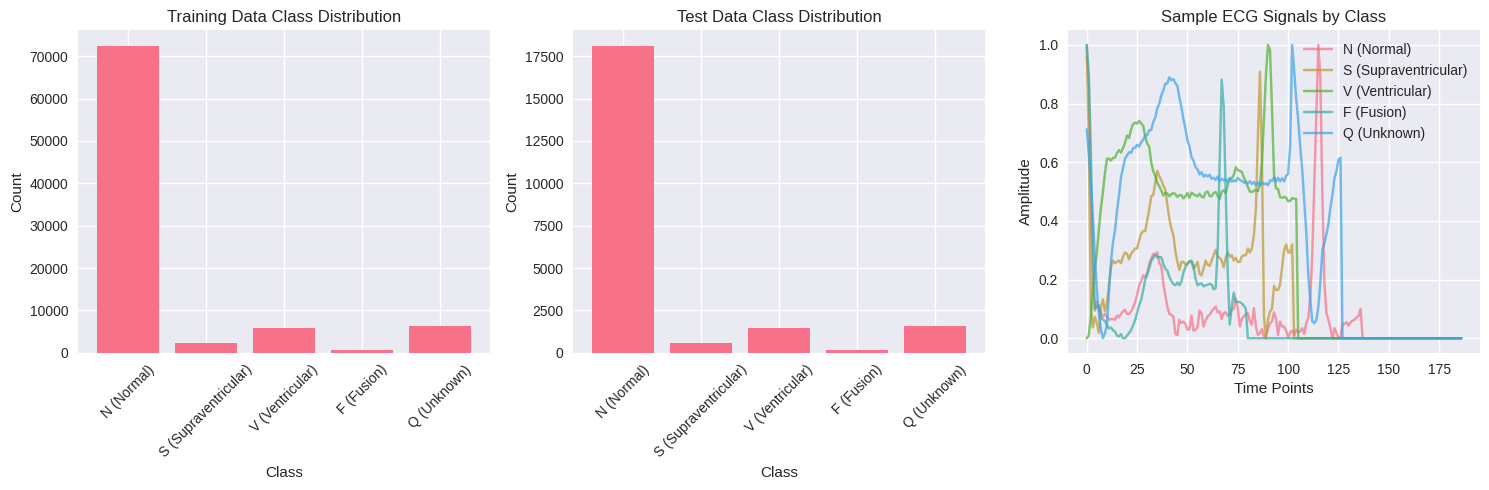


Class Distribution (Training):
Class 0 (N (Normal)): 72470 samples (82.77%)
Class 1 (S (Supraventricular)): 2223 samples (2.54%)
Class 2 (V (Ventricular)): 5788 samples (6.61%)
Class 3 (F (Fusion)): 641 samples (0.73%)
Class 4 (Q (Unknown)): 6431 samples (7.35%)

Signal Statistics:
Signal length: 187 time points
Signal range: [0.000, 1.000]
Mean signal value: 0.174
Signal std: 0.226

🔍 DATA INTEGRITY CHECK:
X_train shape: (87553, 187), dtype: float64
y_train shape: (87553,), dtype: float64
X_train range: [0.000, 1.000]
y_train unique values: [0. 1. 2. 3. 4.]

📊 DATASET SPLITS:
Total training samples: 87553
Training: 70043 samples
Validation: 17510 samples
Test: 21891 samples
Dataset created with 87553 samples
Input shape: torch.Size([87553, 187])
Label shape: torch.Size([87553])
Dataset created with 21891 samples
Input shape: torch.Size([21891, 187])
Label shape: torch.Size([21891])
✅ Datasets created successfully
✅ DataLoaders created successfully
🧪 Testing data loader...
Batch 0: da

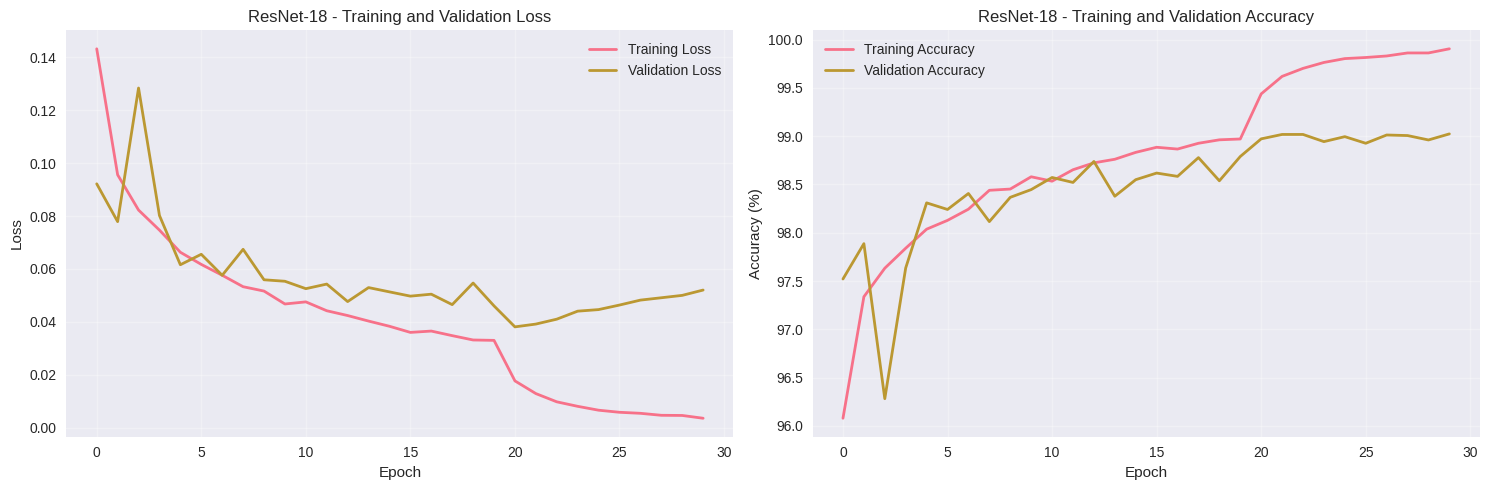

✅ Training history plotted
Sample 0: signal shape torch.Size([1, 187]), label 0
Sample 1: signal shape torch.Size([1, 187]), label 0
Sample 2: signal shape torch.Size([1, 187]), label 0
✅ Evaluation completed

📊 ResNet-18 Test Results:
Test Accuracy: 0.9865

Classification Report:


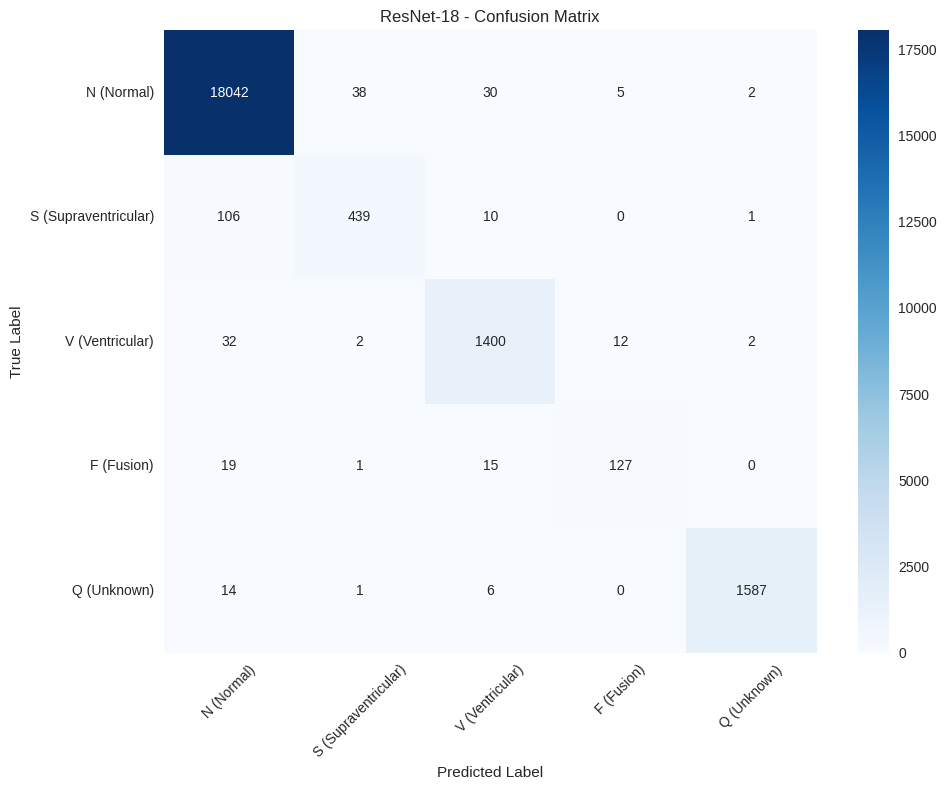

✅ Confusion matrix plotted
✅ Model weights saved
✅ Complete model saved
✅ Training history saved
✅ Metrics saved
✅ Architecture info saved
✅ Summary saved
🎉 Model completely saved to: saved_models/ResNet-18_20250623_151116
✅ Model saved successfully to: saved_models/ResNet-18_20250623_151116

🚀 Training ResNet-34
Total parameters: 7,220,805
Trainable parameters: 7,220,805
✅ Model test passed - Output shape: torch.Size([2, 5])
Training on device: cuda
Starting training for 30 epochs...
First batch - Data shape: torch.Size([64, 1, 187]), Target shape: torch.Size([64])
Data type: torch.float32, Target type: torch.int64
Data range: [0.000, 1.000]
Epoch 1/30, Batch 0, Loss: 1.7375
Epoch 1/30, Batch 100, Loss: 0.4220
Epoch 1/30, Batch 200, Loss: 0.1272
Sample 2: signal shape torch.Size([1, 187]), label 0
Epoch 1/30, Batch 300, Loss: 0.0258
Epoch 1/30, Batch 400, Loss: 0.0522
Epoch 1/30, Batch 500, Loss: 0.1046
Epoch 1/30, Batch 600, Loss: 0.0339
Epoch 1/30, Batch 700, Loss: 0.1242
Epoch 1/30

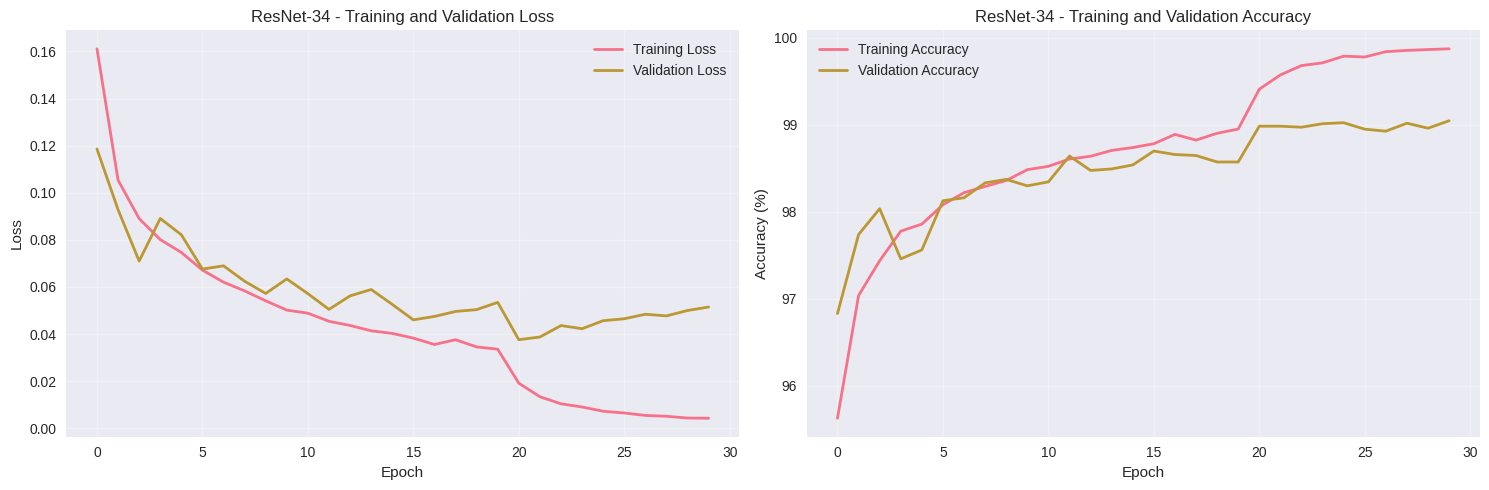

✅ Training history plotted
Sample 0: signal shape torch.Size([1, 187]), label 0
Sample 1: signal shape torch.Size([1, 187]), label 0
Sample 2: signal shape torch.Size([1, 187]), label 0
✅ Evaluation completed

📊 ResNet-34 Test Results:
Test Accuracy: 0.9880

Classification Report:


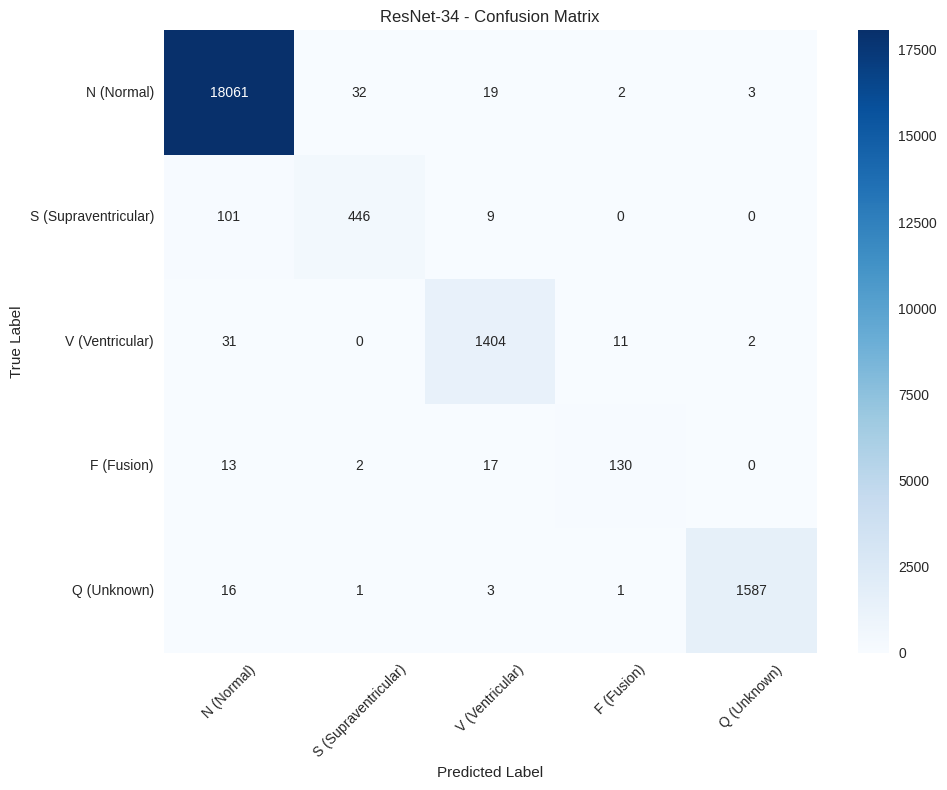

✅ Confusion matrix plotted
✅ Model weights saved
✅ Complete model saved
✅ Training history saved
✅ Metrics saved
✅ Architecture info saved
✅ Summary saved
🎉 Model completely saved to: saved_models/ResNet-34_20250623_152308
✅ Model saved successfully to: saved_models/ResNet-34_20250623_152308

🚀 Training ResNet-50
Total parameters: 15,964,485
Trainable parameters: 15,964,485
✅ Model test passed - Output shape: torch.Size([2, 5])
Training on device: cuda
Starting training for 30 epochs...
First batch - Data shape: torch.Size([64, 1, 187]), Target shape: torch.Size([64])
Data type: torch.float32, Target type: torch.int64
Data range: [0.000, 1.000]
Epoch 1/30, Batch 0, Loss: 2.3520
Sample 2: signal shape torch.Size([1, 187]), label 0
Epoch 1/30, Batch 100, Loss: 0.1722
Epoch 1/30, Batch 200, Loss: 0.0853
Epoch 1/30, Batch 300, Loss: 0.0741
Epoch 1/30, Batch 400, Loss: 0.2332
Epoch 1/30, Batch 500, Loss: 0.0985
Epoch 1/30, Batch 600, Loss: 0.0955
Epoch 1/30, Batch 700, Loss: 0.0652
Epoch 1/

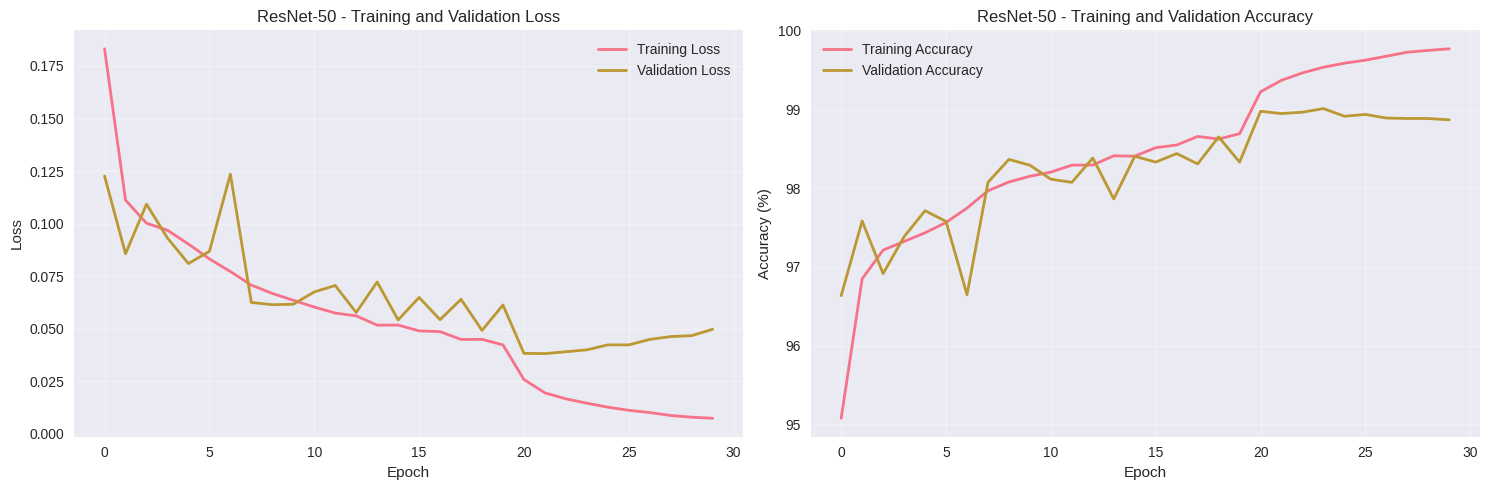

✅ Training history plotted
Sample 0: signal shape torch.Size([1, 187]), label 0
Sample 1: signal shape torch.Size([1, 187]), label 0
Sample 2: signal shape torch.Size([1, 187]), label 0
✅ Evaluation completed

📊 ResNet-50 Test Results:
Test Accuracy: 0.9871

Classification Report:


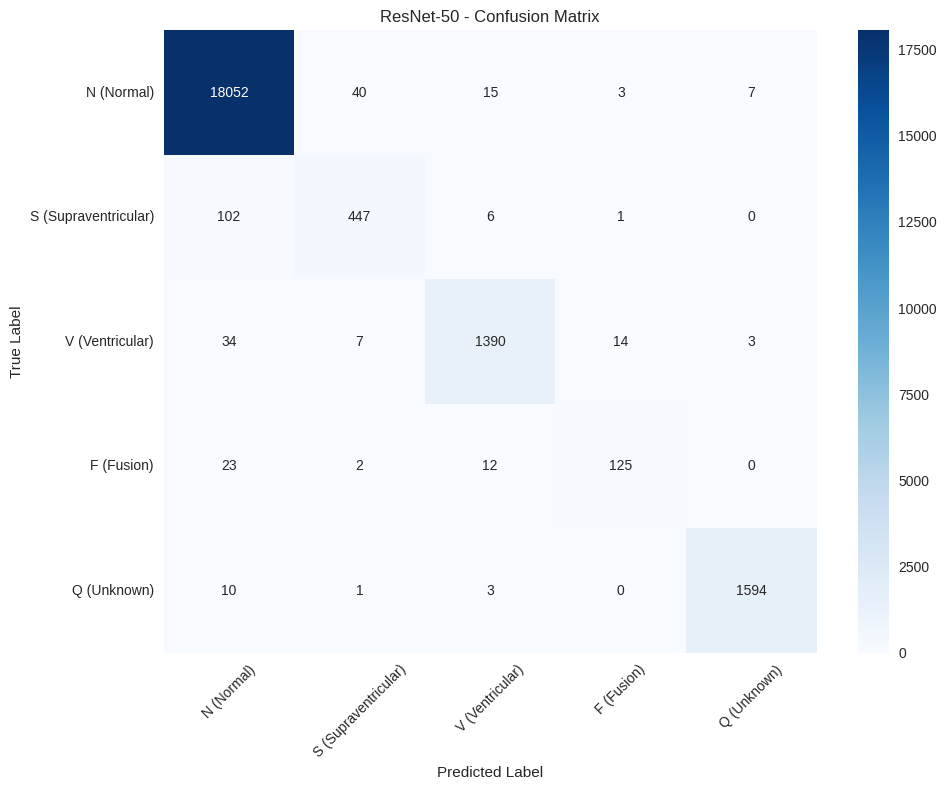

✅ Confusion matrix plotted
✅ Model weights saved
✅ Complete model saved
✅ Training history saved
✅ Metrics saved
✅ Architecture info saved
✅ Summary saved
🎉 Model completely saved to: saved_models/ResNet-50_20250623_155003
✅ Model saved successfully to: saved_models/ResNet-50_20250623_155003

📊 MODEL COMPARISON
    Model Test Accuracy Best Val Accuracy                             Model Path
ResNet-18        0.9865            99.02% saved_models/ResNet-18_20250623_151116
ResNet-34        0.9880            99.05% saved_models/ResNet-34_20250623_152308
ResNet-50        0.9871            99.01% saved_models/ResNet-50_20250623_155003
✅ Comparison results saved


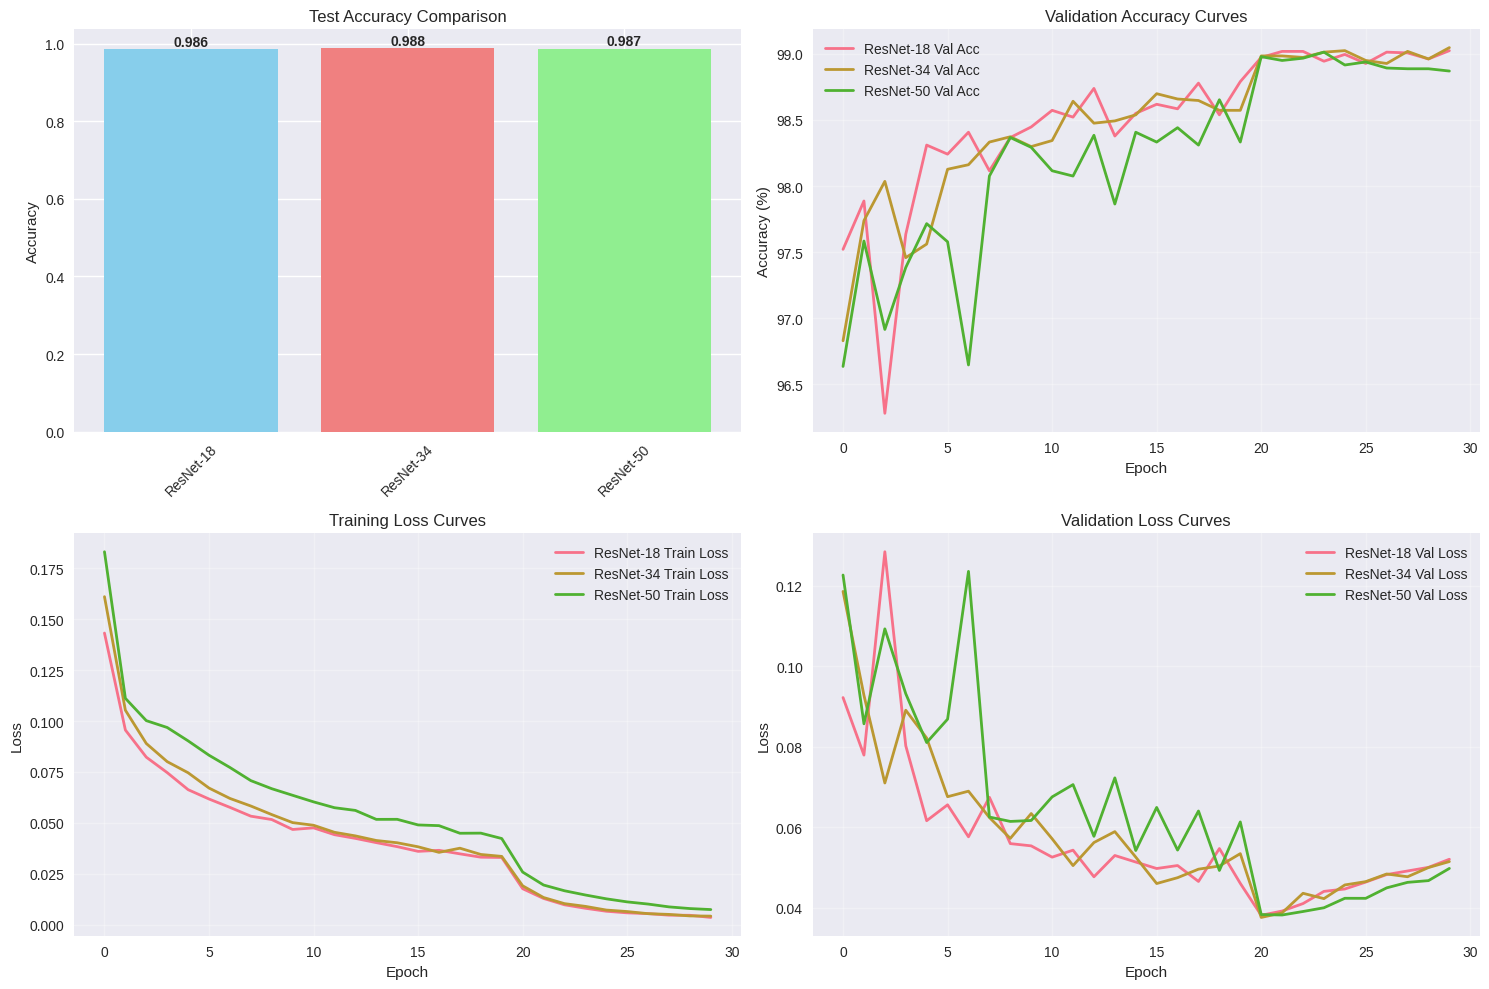

✅ Comparison plots created

🏆 BEST MODEL: ResNet-34
Test Accuracy: 0.9880
Best Validation Accuracy: 99.05%
Model saved at: saved_models/ResNet-34_20250623_152308
✅ Best model info saved

🎯 TRAINING COMPLETE - MODELS PROCESSED!
📁 Results summary:
  • Successfully saved models: 3/3
    ✅ ResNet-18: saved_models/ResNet-18_20250623_151116
    ✅ ResNet-34: saved_models/ResNet-34_20250623_152308
    ✅ ResNet-50: saved_models/ResNet-50_20250623_155003
  • Plots: plots/
  • Results: results/
  • Best model info: results/best_model_info.json
  • Model comparison: results/model_comparison.csv

📈 ADDITIONAL ANALYSES
📊 MODEL COMPLEXITY ANALYSIS
ResNet-18:
  Parameters: 3,846,469
  Size: 14.67 MB

ResNet-34:
  Parameters: 7,220,805
  Size: 27.55 MB

ResNet-50:
  Parameters: 15,964,485
  Size: 60.90 MB

💾 Complexity analysis saved to: results/model_complexity_analysis.csv
✅ Complexity analysis completed

📐 ResNet-18 ARCHITECTURE
INPUT: ECG Signal [1, 187]
│
├── Conv1D(1→64, k=7, s=2) + BatchNorm + R

In [22]:

# ================================
# Additional Analysis Functions
# ================================

def analyze_model_complexity():
    """Analyze computational complexity of different models"""
    models = {
        'ResNet-18': resnet18_1d(num_classes=5),
        'ResNet-34': resnet34_1d(num_classes=5),
        'ResNet-50': resnet50_1d(num_classes=5)
    }
    
    print("📊 MODEL COMPLEXITY ANALYSIS")
    print("="*50)
    
    complexity_data = []
    
    for model_name, model in models.items():
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        # Estimate model size in MB
        param_size_mb = total_params * 4 / (1024 * 1024)  # 4 bytes per float32
        
        complexity_data.append({
            'Model': model_name,
            'Total Parameters': f"{total_params:,}",
            'Trainable Parameters': f"{trainable_params:,}",
            'Model Size (MB)': f"{param_size_mb:.2f}",
            'Memory Footprint': f"{param_size_mb * 2:.2f} MB"  # Rough estimate
        })
        
        print(f"{model_name}:")
        print(f"  Parameters: {total_params:,}")
        print(f"  Size: {param_size_mb:.2f} MB")
        print()
    
    # Save complexity analysis
    complexity_df = pd.DataFrame(complexity_data)
    complexity_df.to_csv('results/model_complexity_analysis.csv', index=False)
    print("💾 Complexity analysis saved to: results/model_complexity_analysis.csv")
    
    return complexity_df

def create_model_architecture_diagram(model, model_name):
    """Create a simple text-based architecture diagram"""
    print(f"\n📐 {model_name} ARCHITECTURE")
    print("="*60)
    
    total_params = sum(p.numel() for p in model.parameters())
    
    print("INPUT: ECG Signal [1, 187]")
    print("│")
    print("├── Conv1D(1→64, k=7, s=2) + BatchNorm + ReLU")
    print("├── MaxPool1D(k=3, s=2)")
    print("│")
    
    if hasattr(model, 'layer1'):
        layers_info = [
            (model.layer1, "Layer1 (64 channels)"),
            (model.layer2, "Layer2 (128 channels)"),
            (model.layer3, "Layer3 (256 channels)"),
            (model.layer4, "Layer4 (512 channels)")
        ]
        
        for layer, name in layers_info:
            num_blocks = len(layer)
            print(f"├── {name}: {num_blocks} blocks")
    
    print("│")
    print("├── AdaptiveAvgPool1D(1)")
    print("├── Dropout(0.5)")
    print("├── Linear(512×expansion → 5)")
    print("│")
    print("OUTPUT: Class Probabilities [5]")
    print(f"\nTotal Parameters: {total_params:,}")

# Run the complete pipeline with comprehensive error handling
if __name__ == "__main__":
    print("🚀 Starting ECG Classification with ResNet")
    print("="*80)
    
    try:
        # Run main training pipeline
        results, model_paths = main()
        
        if results is None:
            print("❌ Training failed. Please check the error messages above.")
            exit(1)
        
        # Additional analyses
        print("\n" + "="*80)
        print("📈 ADDITIONAL ANALYSES")
        print("="*80)
        
        # Model complexity analysis
        try:
            complexity_df = analyze_model_complexity()
            print("✅ Complexity analysis completed")
        except Exception as e:
            print(f"⚠️ Warning: Complexity analysis failed: {e}")
        
        # Architecture diagrams
        try:
            models = {
                'ResNet-18': resnet18_1d(num_classes=5),
                'ResNet-34': resnet34_1d(num_classes=5),
                'ResNet-50': resnet50_1d(num_classes=5)
            }
            
            for model_name, model in models.items():
                create_model_architecture_diagram(model, model_name)
            print("✅ Architecture diagrams created")
        except Exception as e:
            print(f"⚠️ Warning: Architecture diagrams failed: {e}")
        
        # Test inference
        try:
            test_model_inference()
            print("✅ Inference testing completed")
        except Exception as e:
            print(f"⚠️ Warning: Inference testing failed: {e}")
        
        print("\n🎉 ALL TASKS COMPLETED SUCCESSFULLY!")
        print("="*80)
        
    except KeyboardInterrupt:
        print("\n⚠️ Training interrupted by user")
    except Exception as e:
        print(f"\n❌ Unexpected error: {e}")
        import traceback
        traceback.print_exc()
        print("\n💡 Troubleshooting tips:")
        print("1. Check if data files exist in 'data/' directory")
        print("2. Ensure sufficient disk space for saving models")
        print("3. Verify PyTorch installation")
        print("4. Try reducing batch size or number of epochs")
        
    finally:
        print("\n📝 Log saved. Check console output for details.")

Generating ResNet Architecture Visualizations...


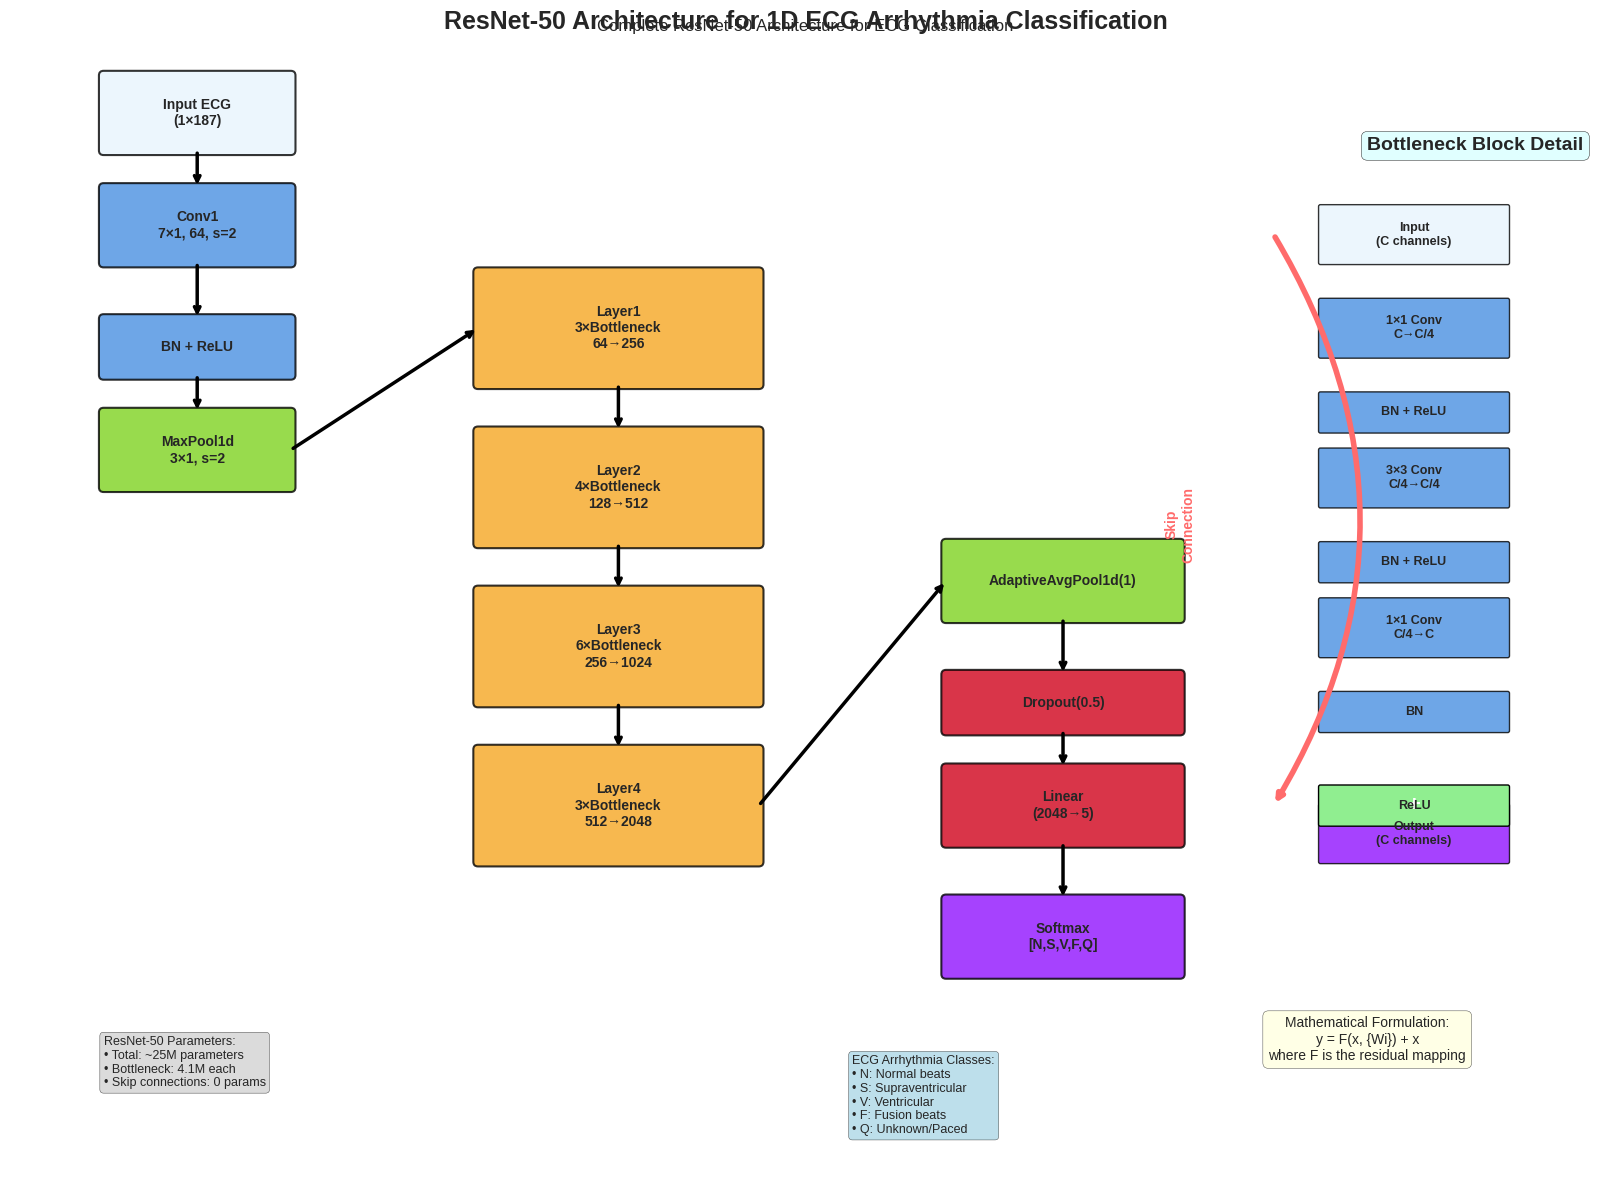

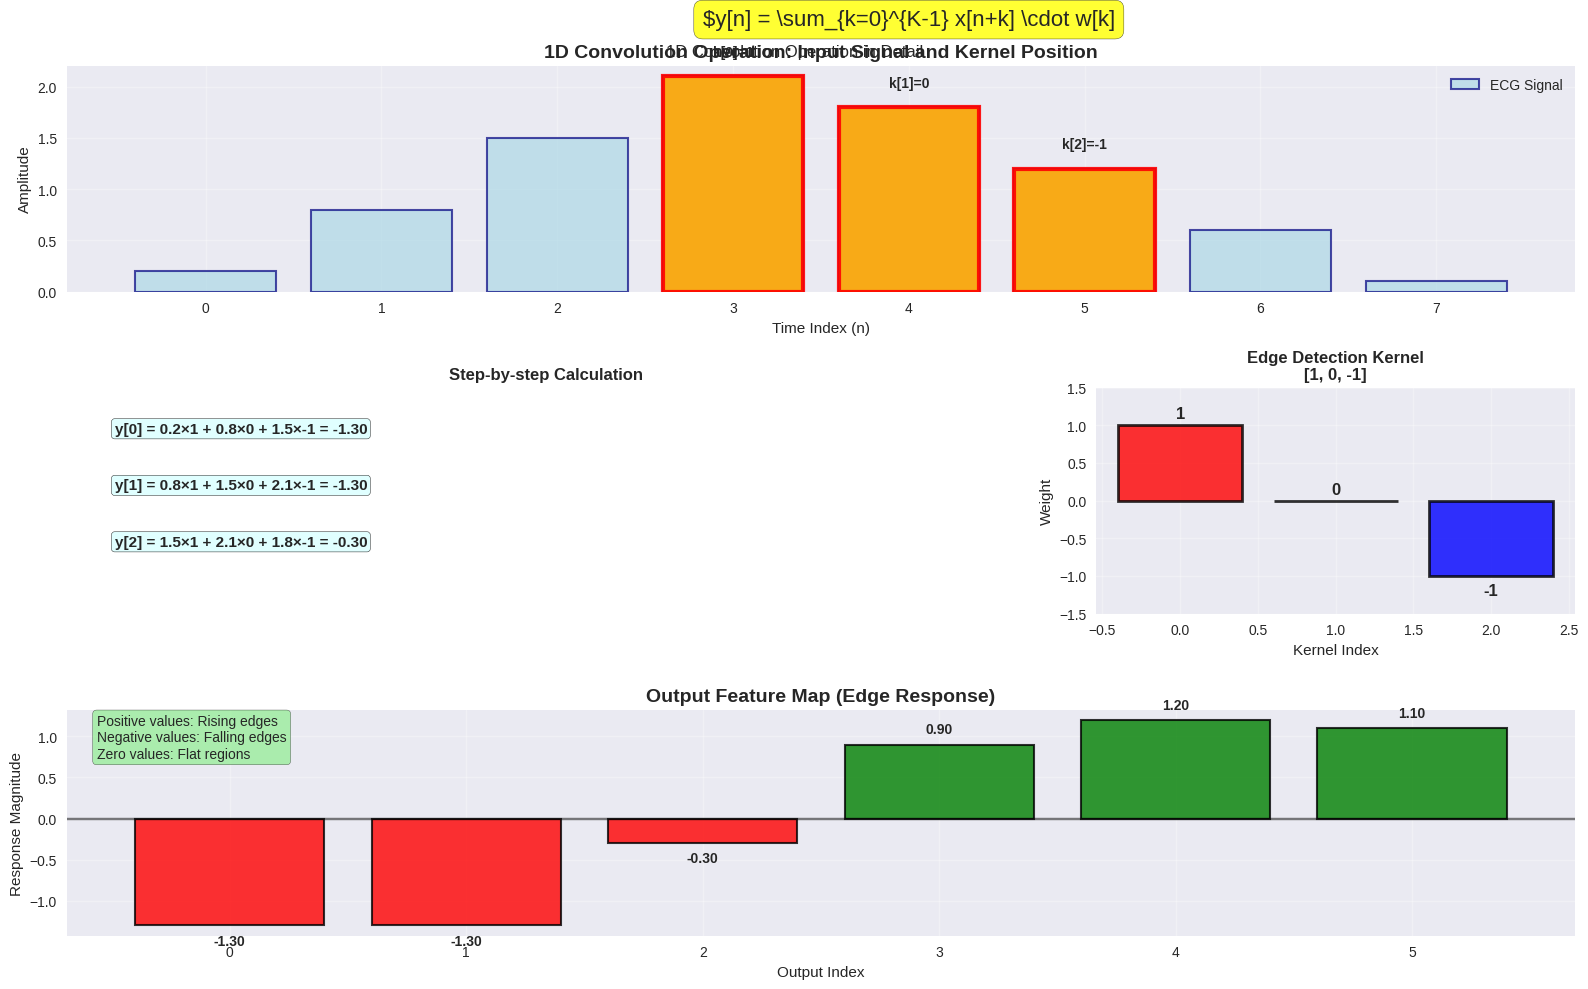

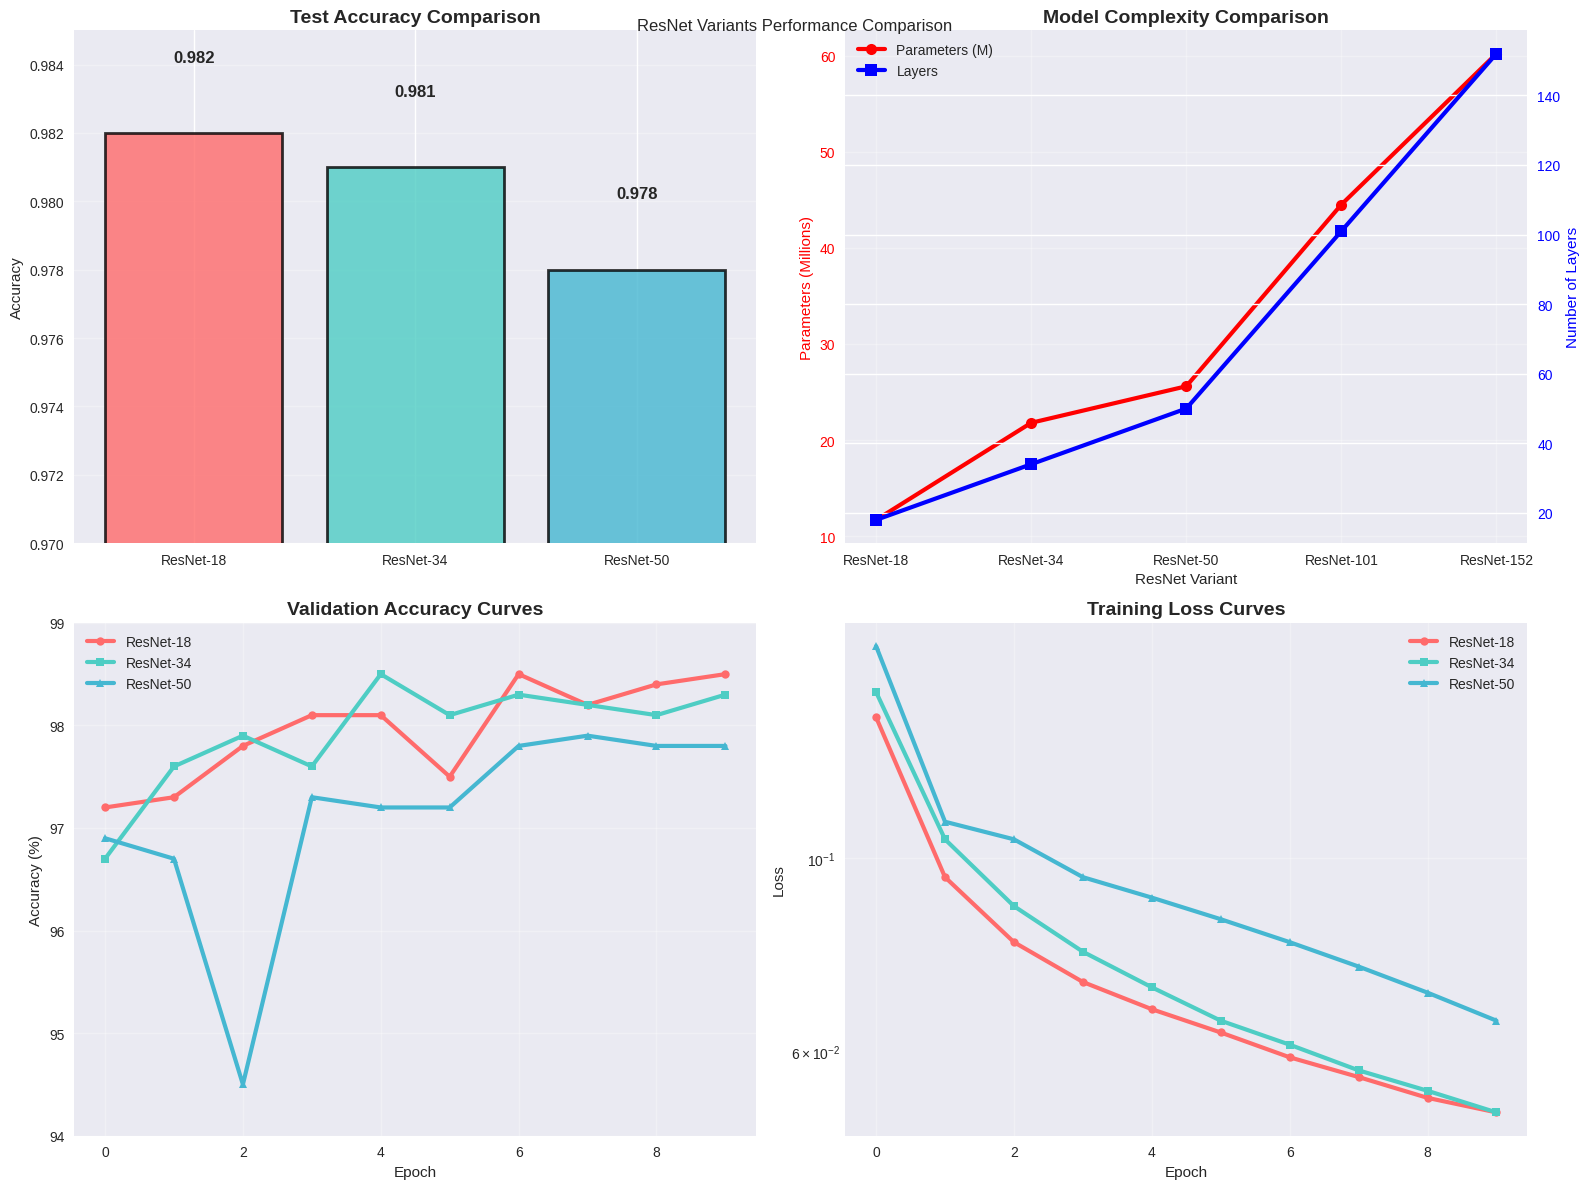

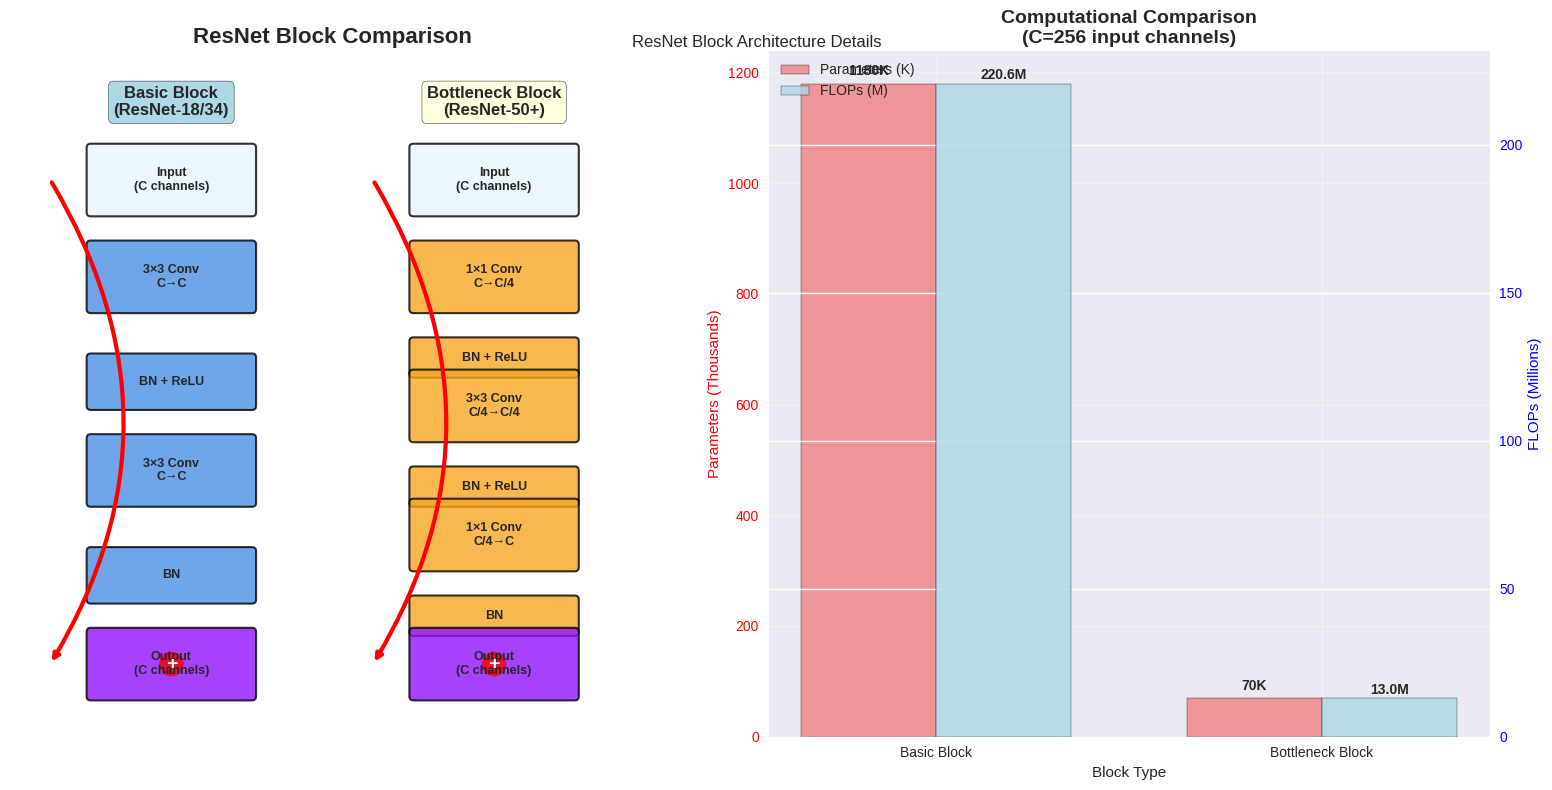

All visualizations generated successfully!


In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch, ConnectionPatch, Circle
import numpy as np
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def plot_resnet_architecture():
    """Plot comprehensive ResNet-50 architecture diagram"""
    fig, ax = plt.subplots(1, 1, figsize=(18, 12))
    
    # Define colors
    colors = {
        'input': '#E8F4FD',
        'conv': '#4A90E2', 
        'bottleneck': '#F5A623',
        'pool': '#7ED321',
        'fc': '#D0021B',
        'output': '#9013FE',
        'skip': '#FF6B6B'
    }
    
    # Main architecture layers
    layers = [
        {'name': 'Input ECG\n(1×187)', 'pos': (1, 11), 'size': (2, 0.8), 'color': colors['input']},
        {'name': 'Conv1\n7×1, 64, s=2', 'pos': (1, 9.8), 'size': (2, 0.8), 'color': colors['conv']},
        {'name': 'BN + ReLU', 'pos': (1, 8.6), 'size': (2, 0.6), 'color': colors['conv']},
        {'name': 'MaxPool1d\n3×1, s=2', 'pos': (1, 7.4), 'size': (2, 0.8), 'color': colors['pool']},
        
        # ResNet Layers
        {'name': 'Layer1\n3×Bottleneck\n64→256', 'pos': (5, 8.5), 'size': (3, 1.2), 'color': colors['bottleneck']},
        {'name': 'Layer2\n4×Bottleneck\n128→512', 'pos': (5, 6.8), 'size': (3, 1.2), 'color': colors['bottleneck']},
        {'name': 'Layer3\n6×Bottleneck\n256→1024', 'pos': (5, 5.1), 'size': (3, 1.2), 'color': colors['bottleneck']},
        {'name': 'Layer4\n3×Bottleneck\n512→2048', 'pos': (5, 3.4), 'size': (3, 1.2), 'color': colors['bottleneck']},
        
        # Final layers
        {'name': 'AdaptiveAvgPool1d(1)', 'pos': (10, 6), 'size': (2.5, 0.8), 'color': colors['pool']},
        {'name': 'Dropout(0.5)', 'pos': (10, 4.8), 'size': (2.5, 0.6), 'color': colors['fc']},
        {'name': 'Linear\n(2048→5)', 'pos': (10, 3.6), 'size': (2.5, 0.8), 'color': colors['fc']},
        {'name': 'Softmax\n[N,S,V,F,Q]', 'pos': (10, 2.2), 'size': (2.5, 0.8), 'color': colors['output']},
    ]
    
    # Draw main architecture layers
    for layer in layers:
        rect = FancyBboxPatch(
            layer['pos'], layer['size'][0], layer['size'][1],
            boxstyle="round,pad=0.05",
            facecolor=layer['color'],
            edgecolor='black',
            linewidth=1.5,
            alpha=0.8
        )
        ax.add_patch(rect)
        
        ax.text(layer['pos'][0] + layer['size'][0]/2, 
                layer['pos'][1] + layer['size'][1]/2,
                layer['name'], 
                ha='center', va='center', 
                fontsize=10, fontweight='bold')
    
    # Draw main flow connections
    main_connections = [
        ((2, 11), (2, 10.6)),           # Input to Conv1
        ((2, 9.8), (2, 9.2)),           # Conv1 to BN+ReLU
        ((2, 8.6), (2, 8.2)),           # BN+ReLU to MaxPool
        ((3, 7.8), (5, 9.1)),           # MaxPool to Layer1
        ((6.5, 8.5), (6.5, 8.0)),       # Layer1 to Layer2
        ((6.5, 6.8), (6.5, 6.3)),       # Layer2 to Layer3
        ((6.5, 5.1), (6.5, 4.6)),       # Layer3 to Layer4
        ((8, 4), (10, 6.4)),            # Layer4 to AdaptiveAvgPool
        ((11.25, 6), (11.25, 5.4)),     # AdaptiveAvgPool to Dropout
        ((11.25, 4.8), (11.25, 4.4)),   # Dropout to Linear
        ((11.25, 3.6), (11.25, 3.0)),   # Linear to Softmax
    ]
    
    for start, end in main_connections:
        ax.annotate('', xy=end, xytext=start,
                   arrowprops=dict(arrowstyle='->', lw=2.5, color='black'))
    
    # Detailed Bottleneck Block (right side)
    ax.text(14.5, 11, 'Bottleneck Block Detail', fontsize=14, fontweight='bold', 
            bbox=dict(boxstyle="round,pad=0.3", facecolor='lightcyan'))
    
    # Detailed bottleneck components
    bottleneck_details = [
        {'name': 'Input\n(C channels)', 'pos': (14, 9.8), 'size': (2, 0.6), 'color': colors['input']},
        {'name': '1×1 Conv\nC→C/4', 'pos': (14, 8.8), 'size': (2, 0.6), 'color': colors['conv']},
        {'name': 'BN + ReLU', 'pos': (14, 8.0), 'size': (2, 0.4), 'color': colors['conv']},
        {'name': '3×3 Conv\nC/4→C/4', 'pos': (14, 7.2), 'size': (2, 0.6), 'color': colors['conv']},
        {'name': 'BN + ReLU', 'pos': (14, 6.4), 'size': (2, 0.4), 'color': colors['conv']},
        {'name': '1×1 Conv\nC/4→C', 'pos': (14, 5.6), 'size': (2, 0.6), 'color': colors['conv']},
        {'name': 'BN', 'pos': (14, 4.8), 'size': (2, 0.4), 'color': colors['conv']},
        {'name': 'Output\n(C channels)', 'pos': (14, 3.4), 'size': (2, 0.6), 'color': colors['output']},
    ]
    
    for detail in bottleneck_details:
        rect = FancyBboxPatch(
            detail['pos'], detail['size'][0], detail['size'][1],
            boxstyle="round,pad=0.02",
            facecolor=detail['color'],
            edgecolor='black',
            linewidth=1,
            alpha=0.8
        )
        ax.add_patch(rect)
        ax.text(detail['pos'][0] + detail['size'][0]/2, 
                detail['pos'][1] + detail['size'][1]/2,
                detail['name'], 
                ha='center', va='center', 
                fontsize=9, fontweight='bold')
    
    # Skip connection (identity/projection)
    skip_start = (13.5, 10.1)
    skip_end = (13.5, 4.0)
    ax.annotate('', xy=skip_end, xytext=skip_start,
               arrowprops=dict(arrowstyle='->', lw=4, color=colors['skip'], 
                             connectionstyle="arc3,rad=-0.3"))
    
    # Skip connection label
    ax.text(12.5, 7, 'Skip\nConnection', fontsize=10, color=colors['skip'], 
            fontweight='bold', rotation=90, ha='center', va='center')
    
    # Addition symbol
    circle = Circle((15, 4.0), 0.15, color=colors['skip'], alpha=0.8)
    ax.add_patch(circle)
    ax.text(15, 4.0, '+', ha='center', va='center', 
            fontsize=16, color='white', fontweight='bold')
    
    # Final ReLU
    rect_relu = FancyBboxPatch(
        (14, 3.8), 2, 0.4,
        boxstyle="round,pad=0.02",
        facecolor='lightgreen',
        edgecolor='black',
        linewidth=1
    )
    ax.add_patch(rect_relu)
    ax.text(15, 4.0, 'ReLU', ha='center', va='center', 
            fontsize=9, fontweight='bold')
    
    # Mathematical formulation box
    formula_text = (
        "Mathematical Formulation:\n"
        "y = F(x, {Wi}) + x\n"
        "where F is the residual mapping"
    )
    ax.text(14.5, 1.5, formula_text, fontsize=10, 
            bbox=dict(boxstyle="round,pad=0.4", facecolor='lightyellow', alpha=0.8),
            ha='center', va='center')
    
    # Parameter count annotation
    param_text = (
        "ResNet-50 Parameters:\n"
        "• Total: ~25M parameters\n"
        "• Bottleneck: 4.1M each\n"
        "• Skip connections: 0 params"
    )
    ax.text(1, 1, param_text, fontsize=9,
            bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray', alpha=0.8))
    
    # ECG classes legend
    classes_text = (
        "ECG Arrhythmia Classes:\n"
        "• N: Normal beats\n"
        "• S: Supraventricular\n"
        "• V: Ventricular\n"
        "• F: Fusion beats\n"
        "• Q: Unknown/Paced"
    )
    ax.text(9, 0.5, classes_text, fontsize=9,
            bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.8))
    
    ax.set_xlim(0, 17)
    ax.set_ylim(0, 12)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('ResNet-50 Architecture for 1D ECG Arrhythmia Classification', 
                fontsize=18, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig

def plot_convolution_detailed():
    """Plot detailed 1D convolution operation with mathematical explanation"""
    fig = plt.figure(figsize=(16, 10))
    
    # Create subplots with custom layout
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1], width_ratios=[2, 1])
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[2, :])
    
    # 1. Input Signal and Kernel
    input_signal = np.array([0.2, 0.8, 1.5, 2.1, 1.8, 1.2, 0.6, 0.1])
    kernel = np.array([1, 0, -1])  # Edge detection kernel
    kernel_size = len(kernel)
    
    # Plot input signal
    x_pos = np.arange(len(input_signal))
    bars1 = ax1.bar(x_pos, input_signal, alpha=0.7, color='lightblue', 
                    edgecolor='navy', linewidth=1.5, label='ECG Signal')
    
    # Highlight current kernel position
    kernel_pos = 3
    for i in range(kernel_size):
        if kernel_pos + i < len(input_signal):
            ax1.bar(kernel_pos + i, input_signal[kernel_pos + i], 
                   alpha=0.9, color='orange', edgecolor='red', linewidth=3)
    
    # Show kernel values above
    for i, val in enumerate(kernel):
        if kernel_pos + i < len(input_signal):
            ax1.text(kernel_pos + i, input_signal[kernel_pos + i] + 0.2, 
                    f'k[{i}]={val}', ha='center', fontsize=10, fontweight='bold')
    
    ax1.set_title('1D Convolution Operation: Input Signal and Kernel Position', 
                 fontsize=14, fontweight='bold')
    ax1.set_xlabel('Time Index (n)')
    ax1.set_ylabel('Amplitude')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add mathematical formula
    formula1 = r'$y[n] = \sum_{k=0}^{K-1} x[n+k] \cdot w[k]'
    ax1.text(len(input_signal)/2, max(input_signal) + 0.5, formula1, 
            ha='center', fontsize=16, 
            bbox=dict(boxstyle="round,pad=0.4", facecolor='yellow', alpha=0.8))
    
    # 2. Step-by-step calculation
    calculation_steps = []
    for pos in range(len(input_signal) - kernel_size + 1):
        step_calc = sum(input_signal[pos + k] * kernel[k] for k in range(kernel_size))
        calculation_steps.append(step_calc)
        
        if pos < 3:  # Show first 3 calculations
            calc_text = f"y[{pos}] = "
            for k in range(kernel_size):
                calc_text += f"{input_signal[pos + k]:.1f}×{kernel[k]}"
                if k < kernel_size - 1:
                    calc_text += " + "
            calc_text += f" = {step_calc:.2f}"
            
            ax2.text(0.05, 0.8 - pos*0.25, calc_text, transform=ax2.transAxes, 
                    fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.2", facecolor='lightcyan'))
    
    ax2.set_title('Step-by-step Calculation', fontsize=12, fontweight='bold')
    ax2.axis('off')
    
    # 3. Kernel visualization
    kernel_x = np.arange(len(kernel))
    bars3 = ax3.bar(kernel_x, kernel, color=['red', 'gray', 'blue'], 
                   alpha=0.8, edgecolor='black', linewidth=2)
    
    for i, (bar, val) in enumerate(zip(bars3, kernel)):
        ax3.text(bar.get_x() + bar.get_width()/2, 
                bar.get_height() + 0.05 if val >= 0 else val - 0.1, 
                f'{val}', ha='center', va='bottom' if val >= 0 else 'top',
                fontsize=12, fontweight='bold')
    
    ax3.set_title('Edge Detection Kernel\n[1, 0, -1]', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Kernel Index')
    ax3.set_ylabel('Weight')
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(-1.5, 1.5)
    
    # 4. Output feature map
    output_x = np.arange(len(calculation_steps))
    bars4 = ax4.bar(output_x, calculation_steps, alpha=0.8, 
                   color=['green' if x > 0 else 'red' for x in calculation_steps],
                   edgecolor='black', linewidth=1.5)
    
    # Annotate each output value
    for i, (bar, val) in enumerate(zip(bars4, calculation_steps)):
        ax4.text(bar.get_x() + bar.get_width()/2, 
                bar.get_height() + 0.1 if val >= 0 else val - 0.1, 
                f'{val:.2f}', ha='center', va='bottom' if val >= 0 else 'top',
                fontsize=10, fontweight='bold')
    
    ax4.set_title('Output Feature Map (Edge Response)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Output Index')
    ax4.set_ylabel('Response Magnitude')
    ax4.grid(True, alpha=0.3)
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # Add interpretation
    interpretation = ("Positive values: Rising edges\nNegative values: Falling edges\nZero values: Flat regions")
    ax4.text(0.02, 0.98, interpretation, transform=ax4.transAxes, 
            fontsize=10, va='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.7))
    
    plt.tight_layout()
    return fig

def plot_resnet_comparison():
    """Plot comparison of different ResNet variants"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Test Accuracy Comparison (from your data)
    models = ['ResNet-18', 'ResNet-34', 'ResNet-50']
    accuracies = [0.982, 0.981, 0.978]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    bars = ax1.bar(models, accuracies, color=colors, edgecolor='black', 
                  linewidth=2, alpha=0.8)
    
    for i, (bar, acc) in enumerate(zip(bars, accuracies)):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    ax1.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0.97, 0.985)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 2. Model Complexity Comparison
    models_complex = ['ResNet-18', 'ResNet-34', 'ResNet-50', 'ResNet-101', 'ResNet-152']
    parameters = [11.7, 21.8, 25.6, 44.5, 60.2]  # in millions
    layers = [18, 34, 50, 101, 152]
    
    ax2_twin = ax2.twinx()
    
    line1 = ax2.plot(models_complex, parameters, 'o-', color='red', linewidth=3, 
                    markersize=8, label='Parameters (M)')
    line2 = ax2_twin.plot(models_complex, layers, 's-', color='blue', linewidth=3, 
                         markersize=8, label='Layers')
    
    ax2.set_xlabel('ResNet Variant')
    ax2.set_ylabel('Parameters (Millions)', color='red')
    ax2_twin.set_ylabel('Number of Layers', color='blue')
    ax2.set_title('Model Complexity Comparison', fontsize=14, fontweight='bold')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2_twin.tick_params(axis='y', labelcolor='blue')
    ax2.grid(True, alpha=0.3)
    
    # Combine legends
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_twin.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # 3. Training Curves (Validation Accuracy)
    epochs = np.arange(0, 10)
    # Based on your provided curves
    resnet18_val = np.array([97.2, 97.3, 97.8, 98.1, 98.1, 97.5, 98.5, 98.2, 98.4, 98.5])
    resnet34_val = np.array([96.7, 97.6, 97.9, 97.6, 98.5, 98.1, 98.3, 98.2, 98.1, 98.3])
    resnet50_val = np.array([96.9, 96.7, 94.5, 97.3, 97.2, 97.2, 97.8, 97.9, 97.8, 97.8])
    
    ax3.plot(epochs, resnet18_val, 'o-', linewidth=3, markersize=6, 
            label='ResNet-18', color='#FF6B6B')
    ax3.plot(epochs, resnet34_val, 's-', linewidth=3, markersize=6, 
            label='ResNet-34', color='#4ECDC4')
    ax3.plot(epochs, resnet50_val, '^-', linewidth=3, markersize=6, 
            label='ResNet-50', color='#45B7D1')
    
    ax3.set_title('Validation Accuracy Curves', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy (%)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(94, 99)
    
    # 4. Loss Curves (Training)
    resnet18_loss = np.array([0.145, 0.095, 0.080, 0.072, 0.067, 0.063, 0.059, 0.056, 0.053, 0.051])
    resnet34_loss = np.array([0.155, 0.105, 0.088, 0.078, 0.071, 0.065, 0.061, 0.057, 0.054, 0.051])
    resnet50_loss = np.array([0.175, 0.110, 0.105, 0.095, 0.090, 0.085, 0.080, 0.075, 0.070, 0.065])
    
    ax4.plot(epochs, resnet18_loss, 'o-', linewidth=3, markersize=6, 
            label='ResNet-18', color='#FF6B6B')
    ax4.plot(epochs, resnet34_loss, 's-', linewidth=3, markersize=6, 
            label='ResNet-34', color='#4ECDC4')
    ax4.plot(epochs, resnet50_loss, '^-', linewidth=3, markersize=6, 
            label='ResNet-50', color='#45B7D1')
    
    ax4.set_title('Training Loss Curves', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Loss')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('log')  # Log scale for better visualization
    
    plt.tight_layout()
    return fig

def plot_bottleneck_details():
    """Plot detailed bottleneck block architecture"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Left: Basic Block vs Bottleneck Block
    # Basic Block (ResNet-18/34)
    basic_layers = [
        {'name': 'Input\n(C channels)', 'pos': (1, 6), 'size': (2, 0.8), 'color': '#E8F4FD'},
        {'name': '3×3 Conv\nC→C', 'pos': (1, 4.8), 'size': (2, 0.8), 'color': '#4A90E2'},
        {'name': 'BN + ReLU', 'pos': (1, 3.6), 'size': (2, 0.6), 'color': '#4A90E2'},
        {'name': '3×3 Conv\nC→C', 'pos': (1, 2.4), 'size': (2, 0.8), 'color': '#4A90E2'},
        {'name': 'BN', 'pos': (1, 1.2), 'size': (2, 0.6), 'color': '#4A90E2'},
        {'name': 'Output\n(C channels)', 'pos': (1, 0), 'size': (2, 0.8), 'color': '#9013FE'},
    ]
    
    # Bottleneck Block (ResNet-50+)
    bottleneck_layers = [
        {'name': 'Input\n(C channels)', 'pos': (5, 6), 'size': (2, 0.8), 'color': '#E8F4FD'},
        {'name': '1×1 Conv\nC→C/4', 'pos': (5, 4.8), 'size': (2, 0.8), 'color': '#F5A623'},
        {'name': 'BN + ReLU', 'pos': (5, 4.0), 'size': (2, 0.4), 'color': '#F5A623'},
        {'name': '3×3 Conv\nC/4→C/4', 'pos': (5, 3.2), 'size': (2, 0.8), 'color': '#F5A623'},
        {'name': 'BN + ReLU', 'pos': (5, 2.4), 'size': (2, 0.4), 'color': '#F5A623'},
        {'name': '1×1 Conv\nC/4→C', 'pos': (5, 1.6), 'size': (2, 0.8), 'color': '#F5A623'},
        {'name': 'BN', 'pos': (5, 0.8), 'size': (2, 0.4), 'color': '#F5A623'},
        {'name': 'Output\n(C channels)', 'pos': (5, 0), 'size': (2, 0.8), 'color': '#9013FE'},
    ]
    
    # Draw blocks
    for layers, title_x in [(basic_layers, 2), (bottleneck_layers, 6)]:
        for layer in layers:
            rect = FancyBboxPatch(
                layer['pos'], layer['size'][0], layer['size'][1],
                boxstyle="round,pad=0.05",
                facecolor=layer['color'],
                edgecolor='black',
                linewidth=1.5,
                alpha=0.8
            )
            ax1.add_patch(rect)
            
            ax1.text(layer['pos'][0] + layer['size'][0]/2, 
                    layer['pos'][1] + layer['size'][1]/2,
                    layer['name'], 
                    ha='center', va='center', 
                    fontsize=9, fontweight='bold')
    
    # Add titles
    ax1.text(2, 7.2, 'Basic Block\n(ResNet-18/34)', ha='center', fontsize=12, 
            fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue'))
    ax1.text(6, 7.2, 'Bottleneck Block\n(ResNet-50+)', ha='center', fontsize=12, 
            fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor='lightyellow'))
    
    # Add skip connections
    for start_x in [0.5, 4.5]:
        ax1.annotate('', xy=(start_x, 0.4), xytext=(start_x, 6.4),
                   arrowprops=dict(arrowstyle='->', lw=3, color='red', 
                                 connectionstyle="arc3,rad=-0.3"))
    
    # Add + symbols
    for x_pos in [2, 6]:
        circle = Circle((x_pos, 0.4), 0.15, color='red', alpha=0.8)
        ax1.add_patch(circle)
        ax1.text(x_pos, 0.4, '+', ha='center', va='center', 
                fontsize=14, color='white', fontweight='bold')
    
    ax1.set_xlim(0, 8)
    ax1.set_ylim(-0.5, 8)
    ax1.set_aspect('equal')
    ax1.axis('off')
    ax1.set_title('ResNet Block Comparison', fontsize=16, fontweight='bold')
    
    # Right: Parameter and computation comparison
    block_types = ['Basic Block', 'Bottleneck Block']
    
    # Assume C=256 input channels
    C = 256
    basic_params = 2 * (3 * 3 * C * C)  # Two 3x3 conv layers
    bottleneck_params = (1 * 1 * C * C//4) + (3 * 3 * C//4 * C//4) + (1 * 1 * C//4 * C)
    
    params = [basic_params/1000, bottleneck_params/1000]  # Convert to thousands
    
    # Computational complexity (FLOPs) - simplified
    basic_flops = basic_params * 187  # Assuming signal length 187
    bottleneck_flops = bottleneck_params * 187
    flops = [basic_flops/1000000, bottleneck_flops/1000000]  # Convert to millions
    
    x_pos = np.arange(len(block_types))
    width = 0.35
    
    bars1 = ax2.bar(x_pos - width/2, params, width, label='Parameters (K)', 
                   color='lightcoral', alpha=0.8, edgecolor='black')
    
    ax2_twin = ax2.twinx()
    bars2 = ax2_twin.bar(x_pos + width/2, flops, width, label='FLOPs (M)', 
                        color='lightblue', alpha=0.8, edgecolor='black')
    
    # Add value labels
    for bar, val in zip(bars1, params):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
                f'{val:.0f}K', ha='center', va='bottom', fontweight='bold')
    
    for bar, val in zip(bars2, flops):
        ax2_twin.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                     f'{val:.1f}M', ha='center', va='bottom', fontweight='bold')
    
    ax2.set_xlabel('Block Type')
    ax2.set_ylabel('Parameters (Thousands)', color='red')
    ax2_twin.set_ylabel('FLOPs (Millions)', color='blue')
    ax2.set_title(f'Computational Comparison\n(C={C} input channels)', 
                 fontsize=14, fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(block_types)
    ax2.tick_params(axis='y', labelcolor='red')
    ax2_twin.tick_params(axis='y', labelcolor='blue')
    
    # Combine legends
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_twin.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Main execution function
def main():
    """Generate all ResNet architecture visualizations"""
    print("Generating ResNet Architecture Visualizations...")
    
    # Generate all plots
    fig1 = plot_resnet_architecture()
    fig1.suptitle('Complete ResNet-50 Architecture for ECG Classification', y=0.98)
    
    fig2 = plot_convolution_detailed()
    fig2.suptitle('1D Convolution Operation in Detail', y=0.95)
    
    fig3 = plot_resnet_comparison()
    fig3.suptitle('ResNet Variants Performance Comparison', y=0.98)
    
    fig4 = plot_bottleneck_details()
    fig4.suptitle('ResNet Block Architecture Details', y=0.95)
    
    # Display all figures
    plt.show()
    
    print("All visualizations generated successfully!")
    return fig1, fig2, fig3, fig4

if __name__ == "__main__":
    figures = main()